## Animal classification 

For this question, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals.

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories.

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

### Marking Rules:

We will mark this question based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark

**Acc_mark 10:**

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

**Efficiency mark 10:**

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

**Report mark 30:**

Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



In [2]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: Haider Ali Lokhand
### Student ID: a1894658
### Comptetion Name: Animal Classification Competition
### Final Results: Trasnfer Learning 3 using resnet18
### ACC:95.0%    FLOPs:3.59G
##################################################################################################################################

In [3]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/cv_assignment3'
# Dataset path. You should change the dataset path to the location that you place the data.


Mounted at /content/drive
/content/drive/My Drive/cv_assignment3


In [5]:
data_dir = 'dataset/dataset'
classes = os.listdir(data_dir)

In [ ]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [ ]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  ailurus-fulgens (5)


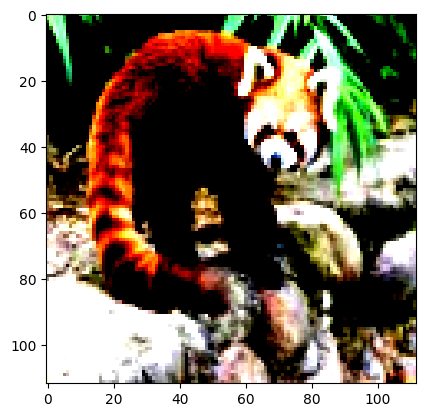

In [ ]:
show_image(*dataset[200])

In [ ]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

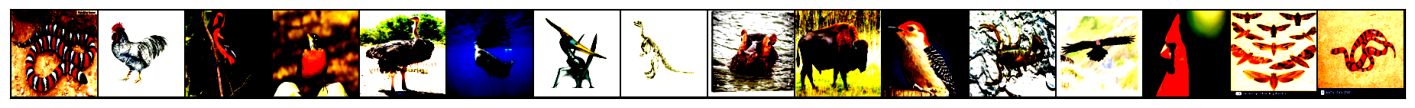

In [ ]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*112*112
output_size = 151

In [ ]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)

        return F.log_softmax(X, dim=1)

In [ ]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0253, -5.0075, -4.9627, -5.0596, -5.0815, -4.9866, -5.0008, -4.9870,
        -5.0678, -5.0146, -5.0684, -4.9802, -4.9810, -5.0258, -5.0535, -5.0307,
        -5.0418, -5.0117, -5.0337, -5.0770, -5.0106, -5.0112, -5.0253, -4.9587,
        -4.9998, -4.9620, -4.9563, -5.0806, -5.0266, -4.9681, -4.9688, -5.0341,
        -5.0871, -5.0054, -5.0148, -4.9946, -5.0253, -4.9978, -4.9086, -5.0187,
        -5.0609, -5.0372, -5.0035, -5.0826, -4.9326, -5.0396, -5.0156, -5.0929,
        -5.0151, -5.0075, -5.0279, -5.0491, -4.9886, -5.0747, -5.0234, -5.0762,
        -5.0536, -5.0433, -5.0373, -4.9688, -5.0567, -5.0227, -5.0481, -5.0432,
        -5.0580, -4.9815, -5.0384, -5.0471, -5.0285, -5.0213, -5.0451, -5.0055,
        -5.0277, -5.0750, -5.0670, -5.0840, -5.0346, -4.9949, -5.0220, -4.9649,
        -5.0837, -5.0014, -5.0467, -4.9690, -4.9925, -4.9640, -5.0435, -5.0278,
        -5.0357, -5.0496, -5.0517, 

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [ ]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.015639781951904, 'val_acc': 0.02187499962747097}]

In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7789, val_loss: 4.5158, val_acc: 0.0854


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2031, val_loss: 4.1520, val_acc: 0.1910


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.6918, val_loss: 3.9611, val_acc: 0.2698


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.2300, val_loss: 3.7690, val_acc: 0.3285


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.7744, val_loss: 3.9248, val_acc: 0.3528


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.3999, val_loss: 4.0226, val_acc: 0.3410


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.0212, val_loss: 4.0528, val_acc: 0.3559


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.6884, val_loss: 4.6306, val_acc: 0.3646


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.4022, val_loss: 4.7770, val_acc: 0.3771


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1351, val_loss: 5.0764, val_acc: 0.3872


In [7]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

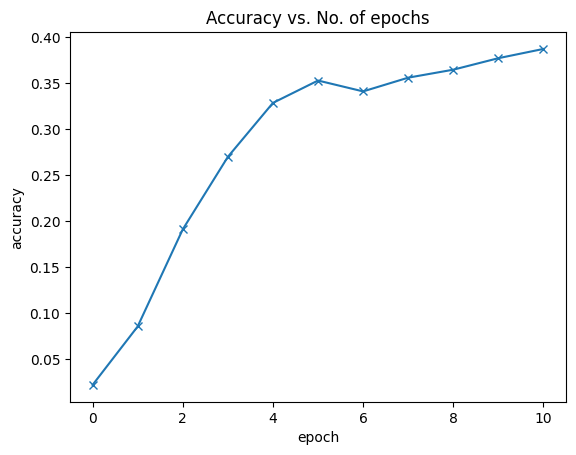

In [ ]:
plot_accuracies(history)

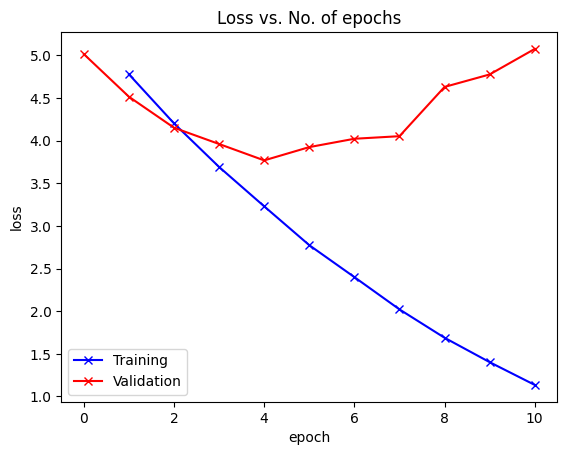

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 5.2631025314331055, 'val_acc': 0.3567708432674408}

##FLOPs

In [ ]:
#The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
#Download the code.
!wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
!mv download FLOPs_counter.py
#!rm -rf download

--2023-08-10 17:43:55--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=ir1lf3vqh41vhcq8bbkoa44van; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=Hk0QlLwZahCiZZojDt0M%2FLEj5FmhaQEgtbUCMJmc64566zZZuTdNt7T7uGeWsxSsouaM89vp74%2B5vPQZidzA8zZxbcAsg%2BpurDSiEE1S2HXdr%2FiFeAkGHTKms8HUSaY%2B; expires=Fri, 11-Aug-2023 08:13:55 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 226.

    The file is already fully retrieved; nothing to do.

'mv' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


# Test Model 1

Data Augmentation, Dropout (0.2)(Due to potential overfitting of curve) and learning rate=0.001 and number of epochs = 15
batch size = 32

In [ ]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
            transforms.RandomRotation(45),

        ])


In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Size of training dataset : 6270


In [ ]:
import torch.nn as nn

class ConvolutionalNetworkWithDropout(ImageClassificationBase):
    def __init__(self, classes, dropout_prob=0.5):
        super().__init__()
        self.num_classes = classes
        self.dropout_prob = dropout_prob

        self.conv1 = nn.Conv2d(3, 64, 5, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(128 * 5 * 5, self.num_classes)

        # Adding dropout layers
        self.dropout1 = nn.Dropout(p=self.dropout_prob)
        self.dropout2 = nn.Dropout(p=self.dropout_prob)
        self.dropout3 = nn.Dropout(p=self.dropout_prob)
        self.dropout4 = nn.Dropout(p=self.dropout_prob)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout3(X)  # Applying dropout

        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout4(X)  # Applying dropout

        X = X.view(-1, 128 * 5 * 5)
        X = self.fc1(X)

        return F.log_softmax(X, dim=1)


In [ ]:
# Model print

num_classes = 151
dropout_prob = 0.2  # Adjust this value as needed
model = ConvolutionalNetworkWithDropout(num_classes, dropout_prob)
model.cuda()
# Rest of the code: Data loading, training loop, evaluation, etc.

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

model = to_device(model, device)

history=[evaluate(model, val_loader)]
history

# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8413, val_loss: 4.6678, val_acc: 0.0870


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.5114, val_loss: 4.4433, val_acc: 0.1214


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.2669, val_loss: 4.2393, val_acc: 0.1905


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.0471, val_loss: 4.1454, val_acc: 0.1896


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.8667, val_loss: 4.0079, val_acc: 0.2365


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.6818, val_loss: 3.9620, val_acc: 0.2610


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.5730, val_loss: 3.7723, val_acc: 0.3020


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.4401, val_loss: 3.8191, val_acc: 0.3065


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.3218, val_loss: 3.9258, val_acc: 0.3065


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.2368, val_loss: 3.6809, val_acc: 0.3386


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.1582, val_loss: 3.5697, val_acc: 0.3793


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.0521, val_loss: 3.5169, val_acc: 0.3966


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [12], train_loss: 2.9722, val_loss: 3.6156, val_acc: 0.3659


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [13], train_loss: 2.8850, val_loss: 3.6030, val_acc: 0.3628


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [14], train_loss: 2.8099, val_loss: 3.5928, val_acc: 0.3761


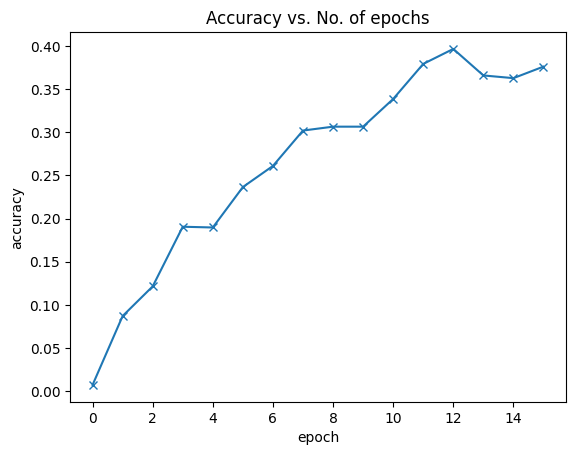

In [ ]:
plot_accuracies(history)

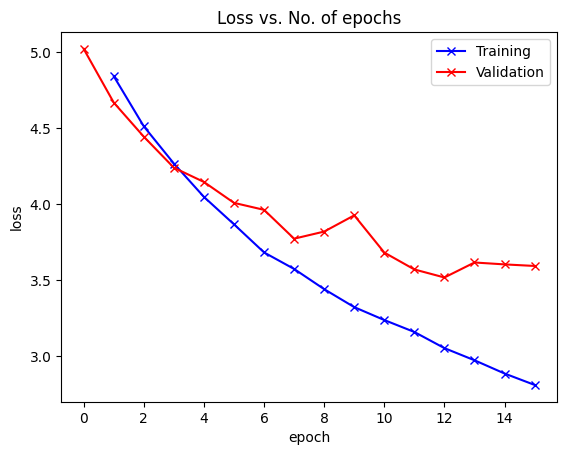

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 3.2880661487579346, 'val_acc': 0.43881580233573914}

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetworkWithDropout(num_classes, dropout_prob)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


# Test Model 2

Implemented batch normalization and dropout at layers 3 and 4, and built a wider and deeper model with one additional hidden layer.

In [ ]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
            transforms.RandomRotation(45),

        ])


# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

import torch.nn as nn

class DeeperConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes, dropout_prob=0.2):
        super().__init__()
        self.num_classes = classes
        self.dropout_prob = dropout_prob

        self.conv1 = nn.Conv2d(3, 64, 5, 1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization

        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, 1)  # Added a wider layer
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, 3, 1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 5 * 5, 512) # Adjusted the fully connected layer
        self.fc2 = nn.Linear(512, self.num_classes)
        self.dropout1 = nn.Dropout(p=self.dropout_prob)
        self.dropout2 = nn.Dropout(p=self.dropout_prob)
        self.dropout3 = nn.Dropout(p=self.dropout_prob)
        self.dropout4 = nn.Dropout(p=self.dropout_prob)
        self.dropout_fc = nn.Dropout(p=self.dropout_prob)  # Added dropout for fully connected layer

    def forward(self, X):
        X = self.bn1(F.relu(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)

        X = self.bn2(F.relu(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)

        X = self.bn3(F.relu(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout3(X)  # Applying dropout

        X = self.bn4(F.relu(self.conv4(X)))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout4(X)  # Applying dropout

        X = X.view(-1, 256 * 5 * 5)
        X = F.relu(self.fc1(X))
        X = self.dropout_fc(X)

        X = self.fc2(X)

        return F.log_softmax(X, dim=1)


# Model print

num_classes = 151
dropout_prob = 0.2  # Adjust this value as needed
model = DeeperConvolutionalNetwork(num_classes, dropout_prob)
# model.cuda()
# Rest of the code: Data loading, training loop, evaluation, etc.

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

model = to_device(model, device)

history=[evaluate(model, val_loader)]
history

# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001



Size of training dataset : 6270
627


In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.9752, val_loss: 4.5606, val_acc: 0.0986


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.5035, val_loss: 4.2920, val_acc: 0.1820


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.2261, val_loss: 4.0640, val_acc: 0.1928


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.9990, val_loss: 3.9469, val_acc: 0.2713


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.8351, val_loss: 3.8895, val_acc: 0.2556


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 3.6834, val_loss: 3.8953, val_acc: 0.2829


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 3.5483, val_loss: 3.6669, val_acc: 0.3199


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 3.4810, val_loss: 3.7558, val_acc: 0.2918


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 3.3572, val_loss: 3.6684, val_acc: 0.3275


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.2437, val_loss: 3.8453, val_acc: 0.3128


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.1629, val_loss: 3.6505, val_acc: 0.3355


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.1139, val_loss: 3.6583, val_acc: 0.3761


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.0528, val_loss: 3.7153, val_acc: 0.3409


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [13], train_loss: 2.9738, val_loss: 3.7135, val_acc: 0.3739


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [14], train_loss: 2.8727, val_loss: 3.8664, val_acc: 0.3779


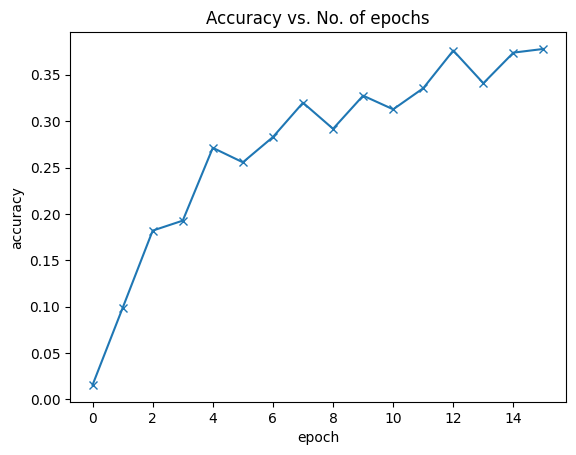

In [ ]:
plot_accuracies(history)

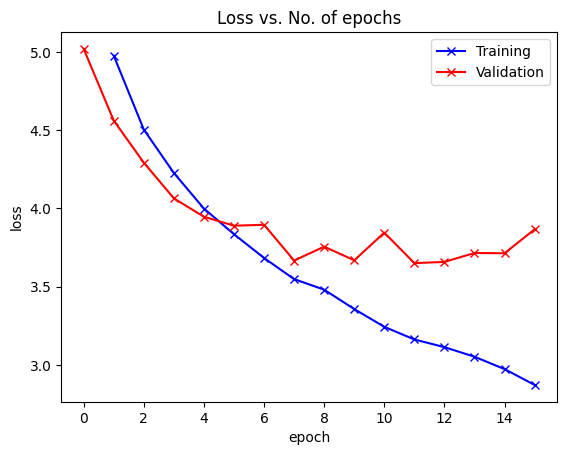

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 3.4997520446777344, 'val_acc': 0.43363484740257263}

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = DeeperConvolutionalNetwork(num_classes, dropout_prob)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.96G


## Test Model 3

In [ ]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(60),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172))
        ])


In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Size of training dataset : 6270


In [ ]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.multi_margin_loss(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.multi_margin_loss(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
import torch.nn as nn

class ConvolutionalNetworkWithDropout(ImageClassificationBase):
    def __init__(self, classes, dropout_prob=0.5):
        super().__init__()
        self.num_classes = classes
        self.dropout_prob = dropout_prob

        self.conv1 = nn.Conv2d(3, 64, 5, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 1)
        self.fc1 = nn.Linear(128 * 5 * 5, self.num_classes)

        # Adding dropout layers
        self.dropout1 = nn.Dropout(p=self.dropout_prob)
        self.dropout2 = nn.Dropout(p=self.dropout_prob)
        self.dropout3 = nn.Dropout(p=self.dropout_prob)
        self.dropout4 = nn.Dropout(p=self.dropout_prob)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout3(X)  # Applying dropout

        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = self.dropout4(X)  # Applying dropout

        X = X.view(-1, 128 * 5 * 5)
        X = self.fc1(X)

        return F.log_softmax(X, dim=1)


In [ ]:
# Model print

num_classes = 151
dropout_prob = 0.2  # Adjust this value as needed
model = ConvolutionalNetworkWithDropout(num_classes, dropout_prob)
#model.cuda()
# Rest of the code: Data loading, training loop, evaluation, etc.

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

model = to_device(model, device)

history=[evaluate(model, val_loader)]
history

# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

627


In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.8055, val_loss: 0.6791, val_acc: 0.0861


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.5713, val_loss: 0.5060, val_acc: 0.1178


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.4559, val_loss: 0.4312, val_acc: 0.1717


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.3738, val_loss: 0.3873, val_acc: 0.2093


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3146, val_loss: 0.3533, val_acc: 0.1922


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.2738, val_loss: 0.3237, val_acc: 0.2735


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.2500, val_loss: 0.3173, val_acc: 0.2627


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2239, val_loss: 0.3119, val_acc: 0.2636


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2010, val_loss: 0.3257, val_acc: 0.2940


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1927, val_loss: 0.2797, val_acc: 0.3444


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1746, val_loss: 0.2858, val_acc: 0.3230


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1610, val_loss: 0.2975, val_acc: 0.3011


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.1473, val_loss: 0.2686, val_acc: 0.3498


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1407, val_loss: 0.2773, val_acc: 0.3333


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1321, val_loss: 0.2861, val_acc: 0.3779


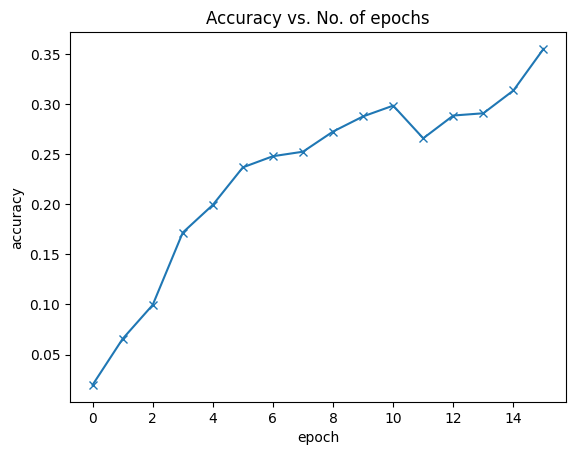

In [ ]:
plot_accuracies(history)

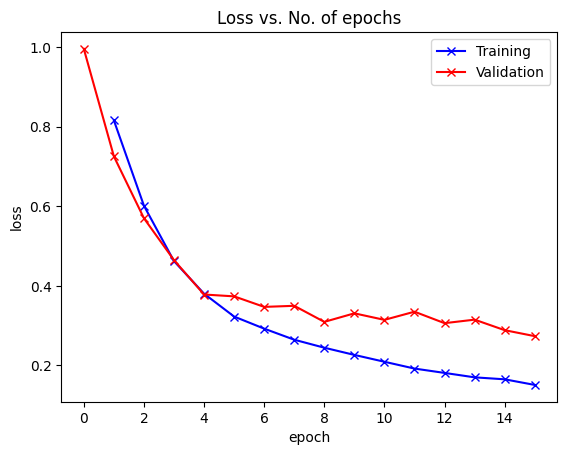

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 0.2702194154262543, 'val_acc': 0.3805098533630371}

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetworkWithDropout(num_classes, dropout_prob)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


# Transfer Learning 1 through Resnet50

In [ ]:
# Using resnet50 model for transfer learning

In [ ]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.models as models

# Performing Image Transformations.
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Checking the dataset training size.
data_dir = 'dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset:', len(dataset))

# Splitting the dataset into training, validation, and testing categories.
torch.manual_seed(10)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

input_size = 3*224*224
output_size = 151

# Model class for transfer learning and freezing inner layers.
class TransferLearningModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)

        # Freeze all layers except the final classification layer
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.resnet50.fc.requires_grad = True

        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

# Instantiate the model and move it to the GPU if available.
num_classes = len(dataset.classes)
model = TransferLearningModel(num_classes)
model.cuda()

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(model, device)
history=[evaluate(model, val_loader)]
history

# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Size of training dataset: 6270
627


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.2147, val_loss: 0.7857, val_acc: 0.9344


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.5917, val_loss: 0.7262, val_acc: 0.9219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.4026, val_loss: 0.5846, val_acc: 0.9569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.2971, val_loss: 0.6090, val_acc: 0.9375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2534, val_loss: 0.5371, val_acc: 0.9594


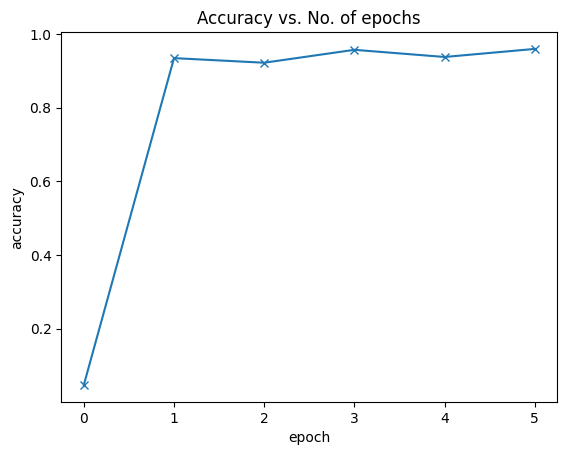

In [ ]:
plot_accuracies(history)

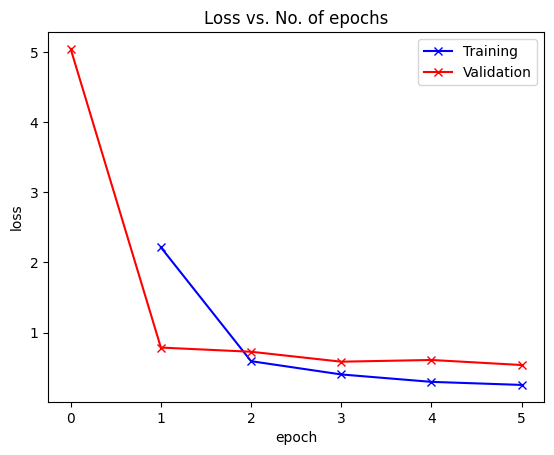

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 0.40933844447135925, 'val_acc': 0.964062511920929}

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = TransferLearningModel(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 8.17G


# Transfer Learning 2 through resnet101

In [ ]:
# Using resnet101 model for transfer learning

In [ ]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.models as models

# Performing Image Transformations.
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Checking the dataset training size.
data_dir = 'dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset:', len(dataset))

# Splitting the dataset into training, validation, and testing categories.
torch.manual_seed(10)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

input_size = 3*224*224
output_size = 151

# Model class for transfer learning and freezing inner layers.
class TransferLearningModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.resnet50 = models.resnet101(pretrained=True)

        # Freeze all layers except the final classification layer
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.resnet50.fc.requires_grad = True

        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

# Instantiate the model and move it to the GPU if available.
num_classes = len(dataset.classes)
model = TransferLearningModel(num_classes)
model.cuda()

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(model, device)
history=[evaluate(model, val_loader)]
history

# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Size of training dataset: 6270


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:03<00:00, 53.3MB/s]


627


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.0500, val_loss: 0.7487, val_acc: 0.9250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.5224, val_loss: 0.5294, val_acc: 0.9594


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.3514, val_loss: 0.5670, val_acc: 0.9438


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.2600, val_loss: 0.6006, val_acc: 0.9500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2363, val_loss: 0.5652, val_acc: 0.9531


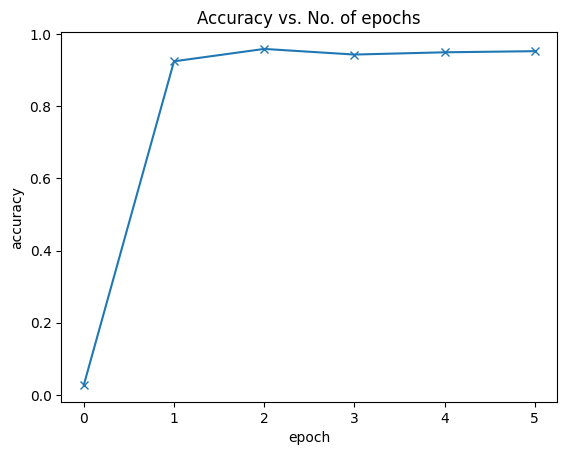

In [ ]:
plot_accuracies(history)

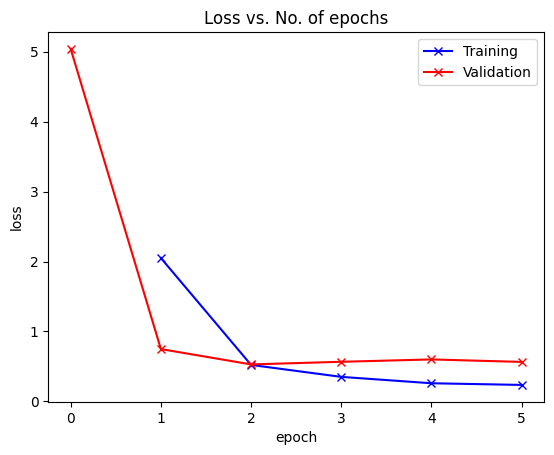

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 0.4656005799770355, 'val_acc': 0.9625000357627869}

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = TransferLearningModel(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 15.61G


# Transfer Learning 3 through resnet18

In [ ]:
# Using resnet18 model for transfer learning

In [ ]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.models as models

# Performing Image Transformations.
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Checking the dataset training size.
data_dir = 'dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset:', len(dataset))

# Splitting the dataset into training, validation, and testing categories.
torch.manual_seed(10)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

input_size = 3*224*224
output_size = 151

# Model class for transfer learning and freezing inner layers.
class TransferLearningModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.resnet50 = models.resnet18(pretrained=True)

        # Freeze all layers except the final classification layer
        for param in self.resnet50.parameters():
            param.requires_grad = False
        self.resnet50.fc.requires_grad = True

        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

# Instantiate the model and move it to the GPU if available.
num_classes = len(dataset.classes)
model = TransferLearningModel(num_classes)
model.cuda()

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(model, device)
history=[evaluate(model, val_loader)]
history

# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Size of training dataset: 6270


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 255MB/s]


627


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.7009, val_loss: 1.1856, val_acc: 0.8906


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9085, val_loss: 0.8176, val_acc: 0.9281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5833, val_loss: 0.6642, val_acc: 0.9500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.4295, val_loss: 0.6063, val_acc: 0.9438


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3422, val_loss: 0.5817, val_acc: 0.9469


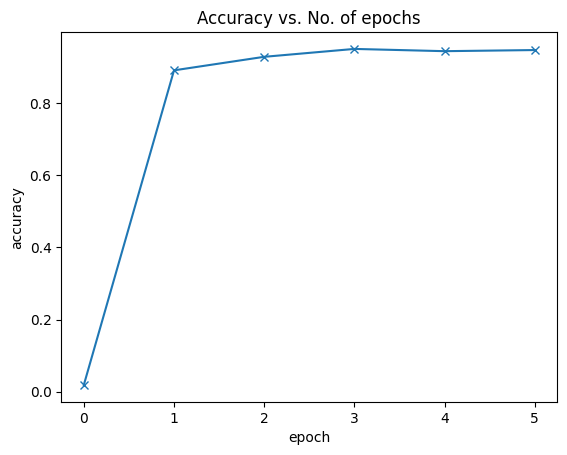

In [ ]:
plot_accuracies(history)

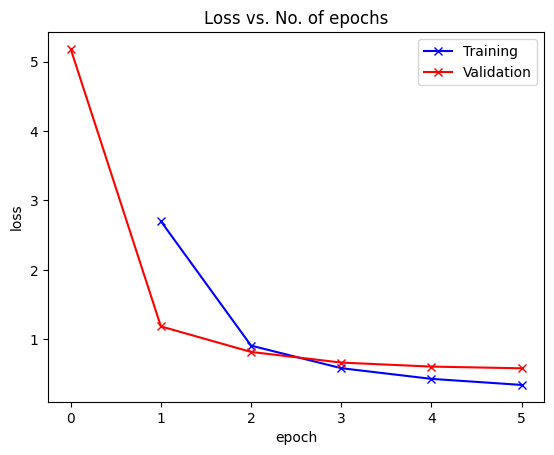

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 0.49581700563430786, 'val_acc': 0.949999988079071}

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = TransferLearningModel(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 3.59G


# Transfer Learning 4 Efficient Net

In [6]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.models as models

# Performing Image Transformations.
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Checking the dataset training size.
data_dir = 'dataset/dataset'
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset:', len(dataset))

# Splitting the dataset into training, validation, and testing categories.
torch.manual_seed(10)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

input_size = 3*224*224
output_size = 151

# Model class for transfer learning and freezing inner layers.
class TransferLearningModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.resnet50 = models.efficientnet_b0(pretrained=True)

        # Freeze all layers except the final classification layer
        for param in self.resnet50.parameters():
            param.requires_grad = False

        self.resnet50.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.resnet50(x)

# Instantiate the model and move it to the GPU if available.
num_classes = len(dataset.classes)
model = TransferLearningModel(num_classes)
model.cuda()

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model = to_device(model, device)
history=[evaluate(model, val_loader)]
history

# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Size of training dataset: 6270


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 220MB/s]


627


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.7533, val_loss: 1.3541, val_acc: 0.9156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9499, val_loss: 0.8785, val_acc: 0.9313


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6109, val_loss: 0.7134, val_acc: 0.9406


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.4565, val_loss: 0.7036, val_acc: 0.9375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3657, val_loss: 0.6201, val_acc: 0.9500


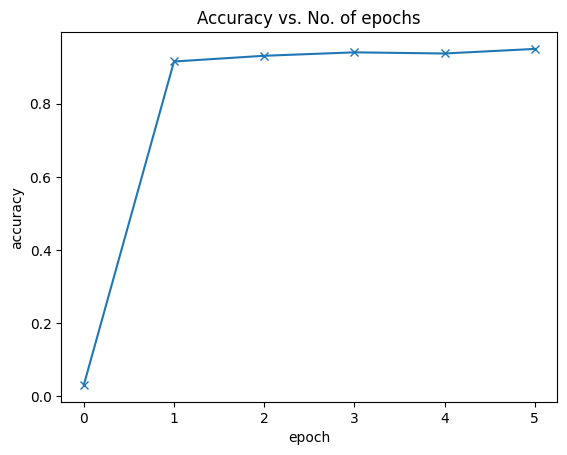

In [8]:
plot_accuracies(history)

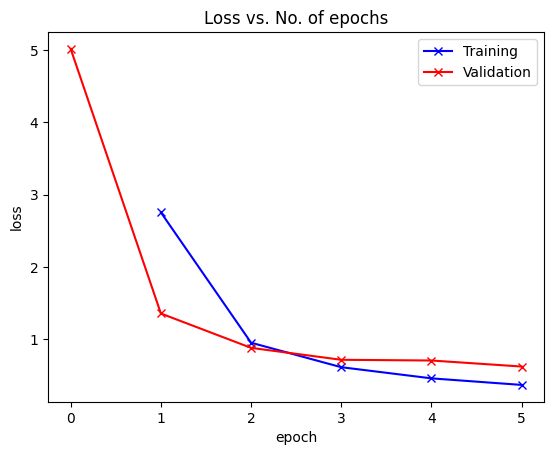

In [9]:
plot_losses(history)

In [10]:
evaluate(model, test_loader)

{'val_loss': 0.6366989016532898, 'val_acc': 0.932812511920929}

In [11]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = TransferLearningModel(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.76G
